# Spatial Encoding

To create images of the net magnetization, magnetic field gradients are applied in order to modulate the resonance frequency as a function of position.  This section describes the effect of magnetic field gradients during data acquisition to create spatial encoding, and introduces the intuition behind frequency and phase encoding.

## Learning Goals

1. Describe how images are formed
    * Describe the effects of gradients on the signal
    * Understand how frequency encoding works
    * Understand how phase encoding works


## Effects of Magnetic Field Gradients

Applied magnetic field gradients change the magnetic field linearly with position:

$$\Delta B_z = \vec{G}\cdot\vec{r}$$

which leads to linear variation in the resonance frequency as a function of position:

$$ f = \bar \gamma \ \vec{G}\cdot\vec{r} $$

This forms the basis for spatial encoding, where fundamentally position is encoded in the frequency of the net magnetization.  

The received signal in MRI is an accumulation over space of all the net magnetizations, so without gradients there is no fine spatial encoding.  (The RF coil sizes can provide some spatial encoding, but on the order of cm.)

Reconstructing images from MRI relies on the Fourier Transform in order to convert the spatial information encoded in frequency into space.  The specifics of this are described later.

## Frequency and Phase encoding, or FT Imaging

By far the most common way to perform spatial encoding is using so-called "frequency encoding" and "phase encoding".
This is also known FT imaging, since we reconstruct images with a 2D Fourier Transform.

It consists of 2 types of encoding:
1. Frequency encoding - one dimension is encoded using a constant gradient applied during data acquisition
1. Phase encoding - additional dimensions are encoded using gradient applied before data acquisition.  This gradient is incremented to provide complete spatial encoding.  Phase encoding is applied in 1 dimension for 2D imaging, and 2 dimensions for 3D imaging

This approach is referred to as Cartesian k-space trajectory, which the name refers to the fact that data is sampled on a regularly spaced grid in k-space, which is introduced later.



### Frequency Encoding

In this approach, one dimension of the object is encoded using "frequency encoding".  This means that, after RF excitation, a magnetic field gradient is turned on and the signal is read out.  The frequencies present in the signal correspond to given spatial locations.  By convention, this is applied in the x-direction (but in practice can be rotated to any direction);

$$f = \bar \gamma G_{xr} x$$
where $G_{xr}$ is the readout gradient amplitude.  Therefore, the position is proportional to the frequency:

$$ x = \frac{f}{\bar \gamma G_{xr}}$$

From frequency encoding data alone, a 1D image can be reconstructed with an inverse Fourier Transform.

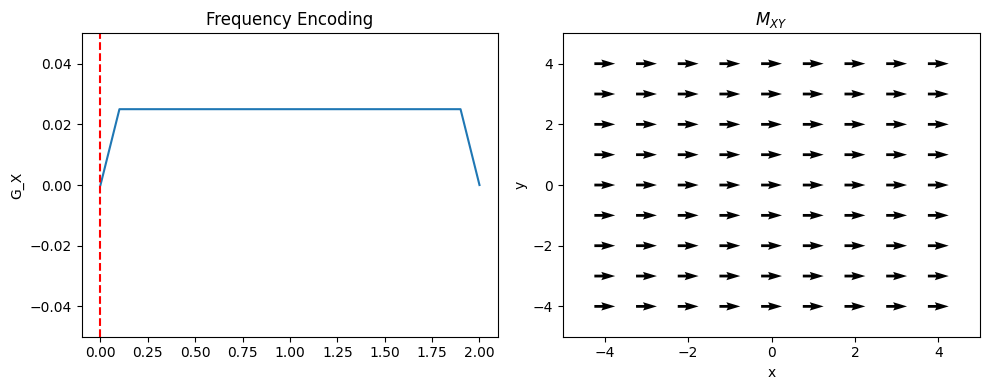

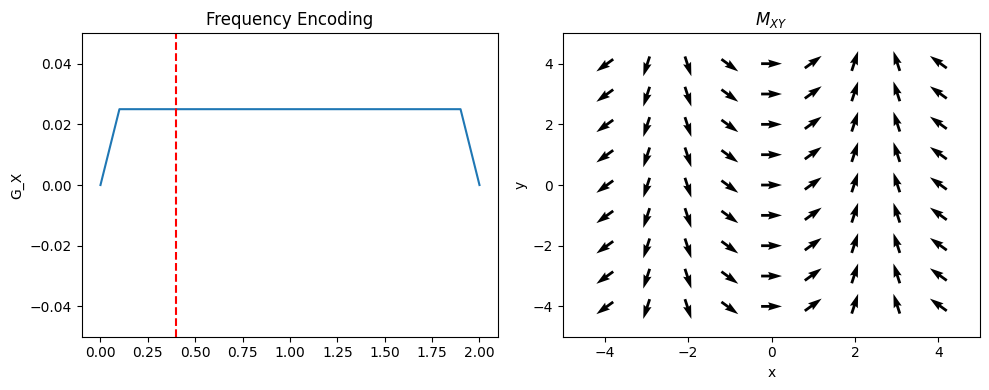

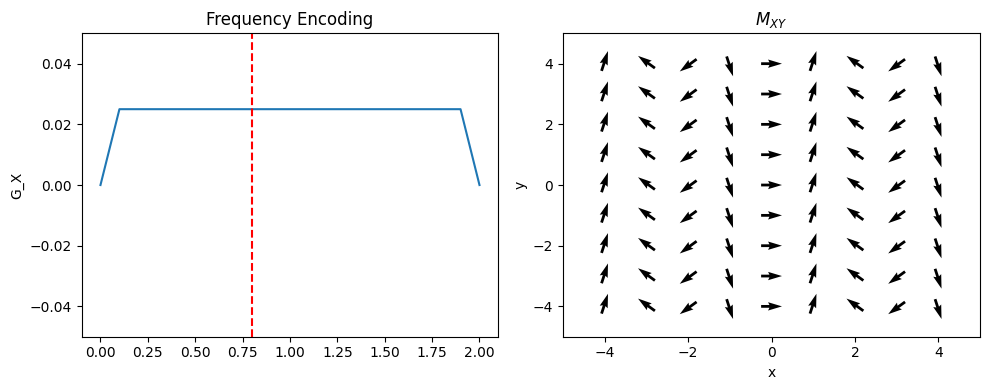

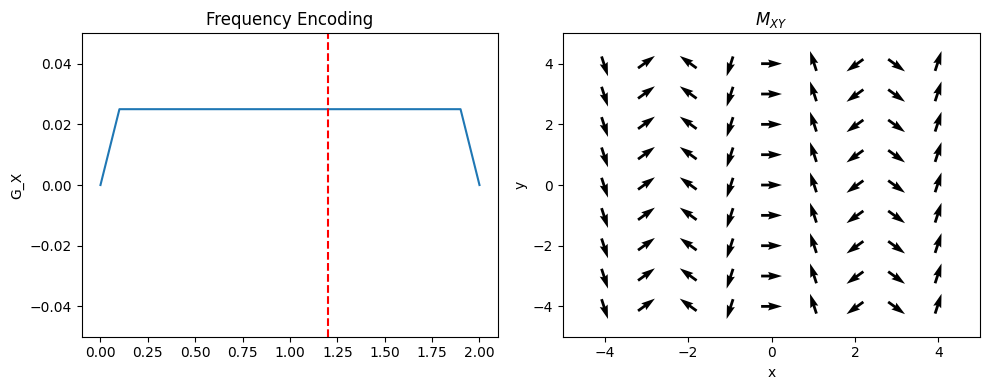

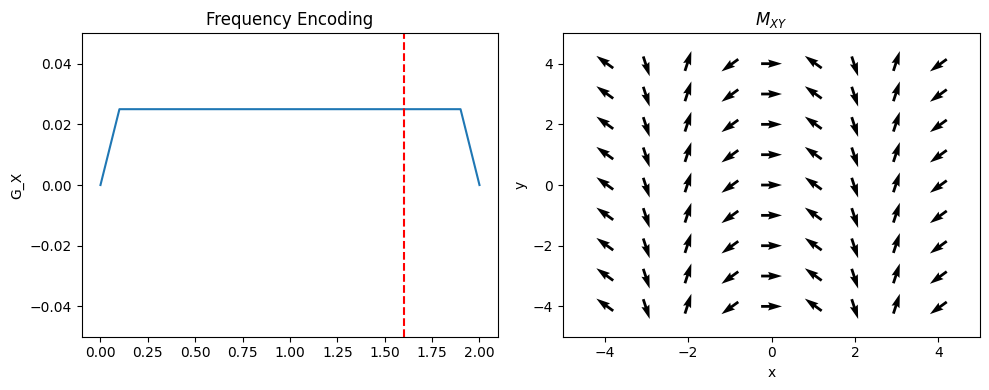

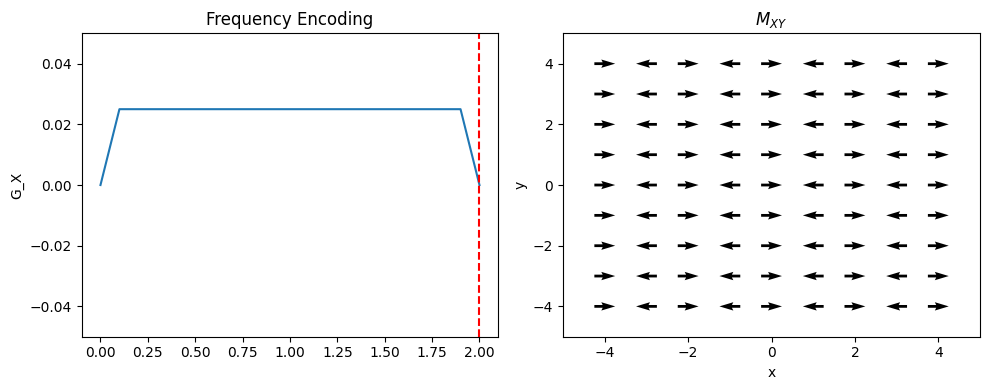

In [6]:
import numpy as np
import matplotlib.pyplot as plt

N = 8

# simulate frequency encoding
Mxy = np.ones((N+1, N+1), dtype=complex)

x = np.arange(-N/2, N/2+1)
x, y = np.meshgrid(x, x)
Splot = 0.5

kFE = 1/2
dt = 0.1
Tfe = 2

GAMMA = 42.58

for tfe in np.linspace(0, 1, 6) * Tfe:
    phase_x = 2 * np.pi * kFE * x * tfe / Tfe
    Mxy_FE = Mxy * np.exp(1j * phase_x)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    t_axis = np.arange(0, Tfe+dt, dt)
    plt.plot(t_axis, np.concatenate([[0], np.ones(len(t_axis)-2)*kFE/(Tfe/dt), [0]]))
    plt.plot([tfe, tfe], [-0.05, 0.05], 'r--')
    plt.ylim([-0.05, 0.05])
    plt.ylabel('G_X')
    plt.title('Frequency Encoding')

    plt.subplot(1, 2, 2)
    plt.quiver(x - np.real(Mxy_FE)*Splot/2, y - np.imag(Mxy_FE)*Splot/2,
               np.real(Mxy_FE), np.imag(Mxy_FE), scale=10/Splot)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-N/2-1, N/2+1])
    plt.ylim([-N/2-1, N/2+1])
    plt.title(r'$M_{XY}$')
    plt.tight_layout()
    plt.show()


## Phase Encoding

Typically the 2nd (and optionally 3rd) dimensions of the object are encoded using "phase encoding".  This means that, after RF excitation but before the frequency encoding gradient, a pulsed gradient is applied such that the location is encoded in the phase of the next magnetization:

$$ \Phi(n) = \gamma (-G_{yp} + (n-1) G_{yi} ) t_y y $$

This measurement is repeated for $n = 1, \ldots, N_{PE}$.  $G_{yp}$ is the maximum phase encoding gradient strength, $G_{yi}$ is the phase encoding gradient amplitude increment, and $t_y$ is the phase encoding gradient duration.  Note that $2 G_{yp} = (N_{PE} - 1) G_{yi}$.

**This is equivalent to taking different samples of a frequency encoding gradient.**

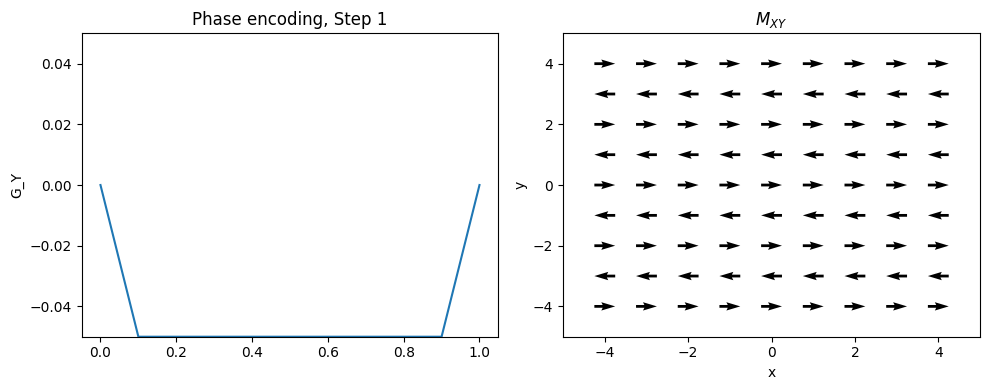

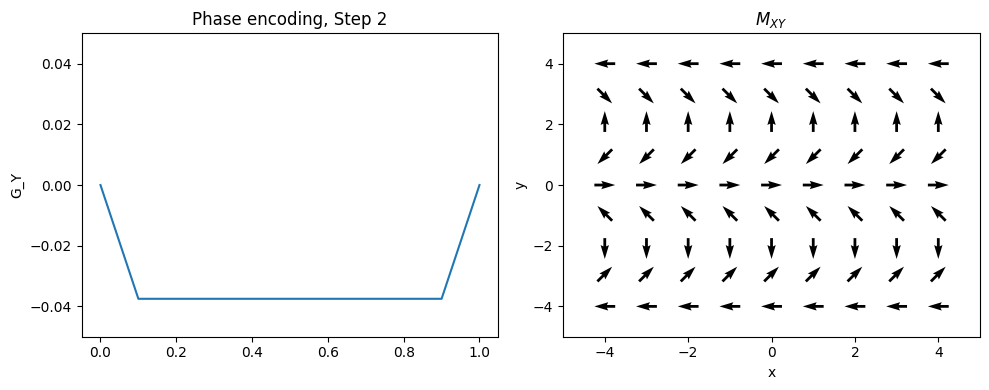

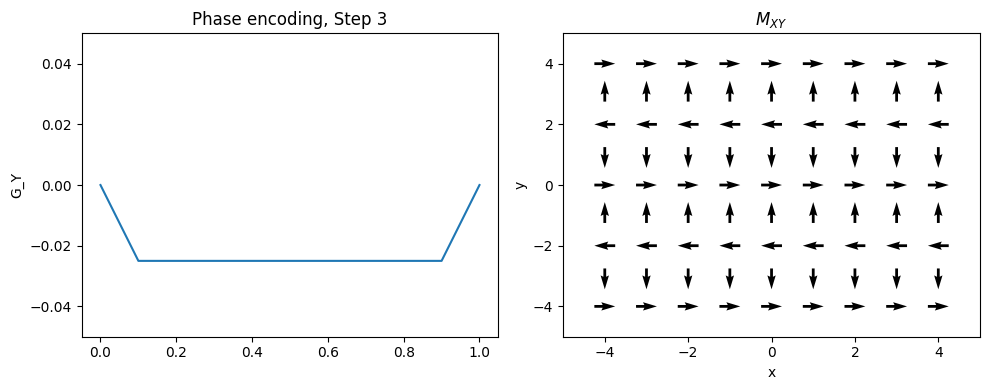

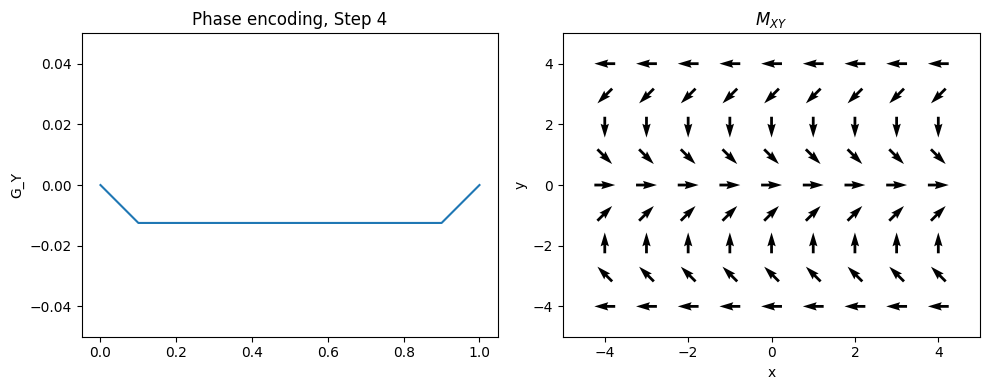

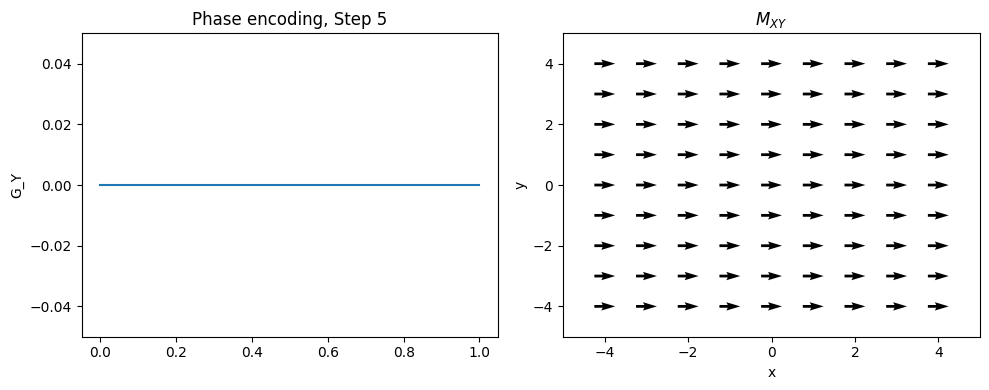

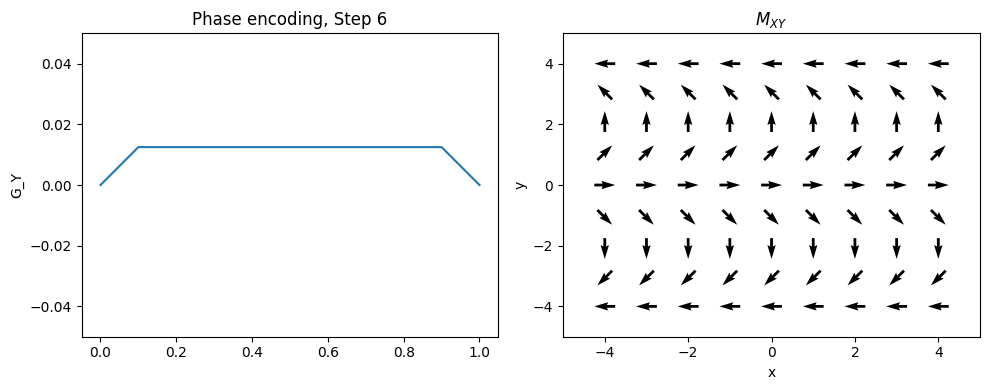

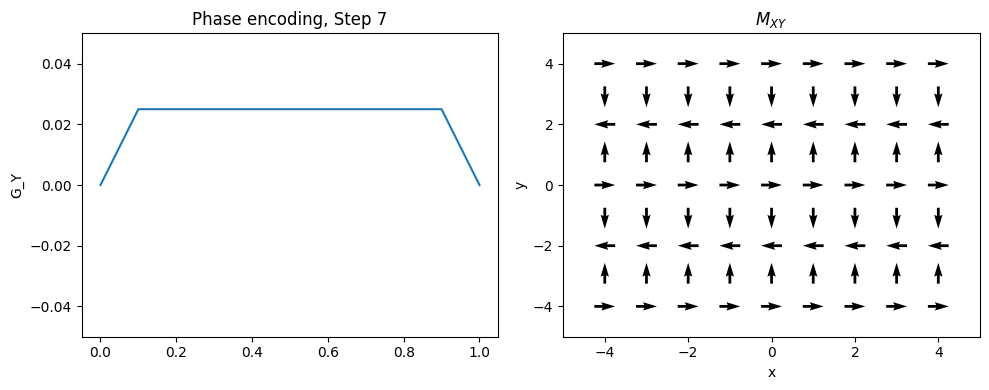

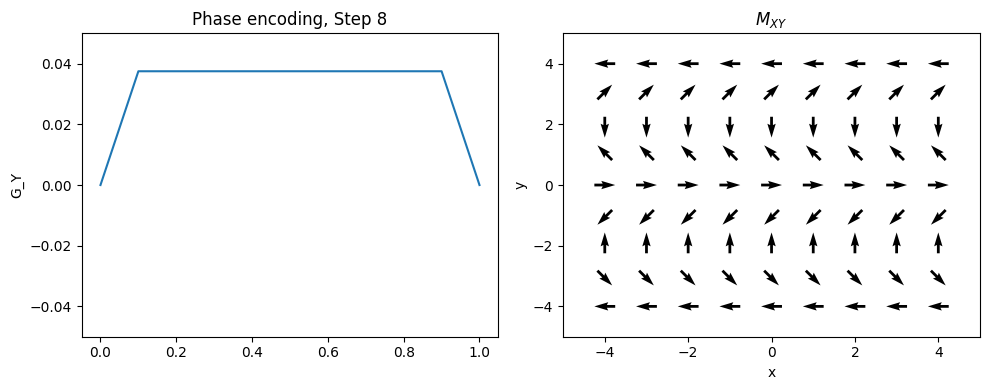

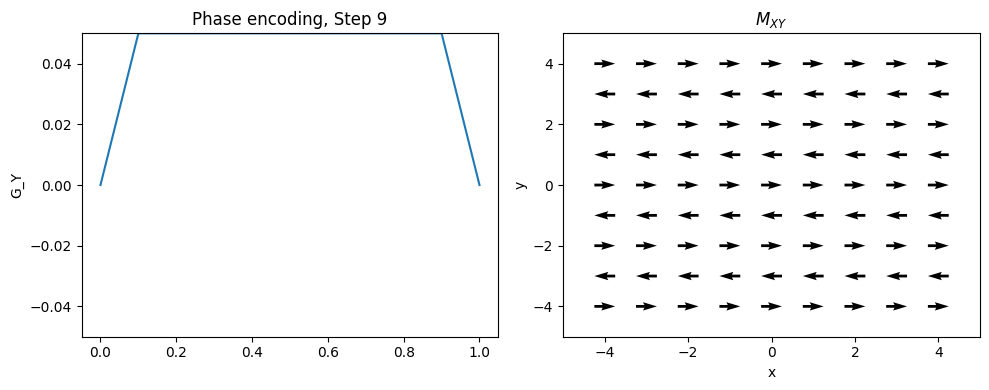

In [7]:
# 2D object: simulate frequencies + phase encoding

kPE = np.arange(-N/2, N/2+1) / N  # phase encoding steps
Tpe = 1

for Ipe, kpe in enumerate(kPE):
    tpe = Tpe  # only using tpe = Tpe as in the original code
    phase_y = 2 * np.pi * kpe * y * tpe / Tpe
    Mxy_PE = Mxy * np.exp(1j * phase_y)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    t_axis = np.arange(0, Tpe + dt, dt)
    # Gradient waveform: 0, plateau, 0
    grad = np.concatenate([[0], np.ones(len(t_axis)-2) * kpe / (Tpe/dt), [0]])
    plt.plot(t_axis, grad)
    plt.ylim([-0.05, 0.05])
    plt.ylabel('G_Y')
    plt.title(f'Phase encoding, Step {Ipe+1}')

    plt.subplot(1, 2, 2)
    plt.quiver(x - np.real(Mxy_PE)*Splot/2, y - np.imag(Mxy_PE)*Splot/2,
               np.real(Mxy_PE), np.imag(Mxy_PE), scale=10/Splot)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-N/2-1, N/2+1])
    plt.ylim([-N/2-1, N/2+1])
    plt.title(r'$M_{XY}$')
    plt.tight_layout()
    plt.show()


## Frequency and Phase Encoding

The following simulation of the net magnetizations shows how first the phase encoding gradient ($G_Y$) creates some phase variation in $y$, and then during the frequency encoding gradient ($G_X$) the net magnetizations rotate at varying frequencies depending on their $x$ position:

![frequency_phase_encoding-simple-Mxy.gif](images/frequency_phase_encoding-simple-Mxy.gif)

Instead of viewing the net magnetizations, we can also visualize this encoding as a map of the phase of the transverse magnetization:

![frequency_phase_encoding-simple-image_phase.gif](images/frequency_phase_encoding-simple-image_phase.gif)

(See ``spatial_encoding_Mxy_illustration.m`` for code generating this movie)



## 2D FT Imaging Pulse Sequence

The following pulse sequence diagram shows a Cartesian 2D FT sequence with frequency and phase encoding including relevant pulse amplitudes and durations.  A gradient-echo sequence is shown, and the principles can simply be extended to a spin-echo sequence.  Idealized rectangular gradients are shown for simplicity.

![Pulse Sequence Diagram](images/pulse_sequence-diagram-Cartesian-parameters.png)